# Anatomical Predictors of Laminar Inference Accuracy

In [Szul et al., 2025, Beyond deep versus superficial: true laminar inference with MEG](https://doi.org/10.1101/2025.05.28.656642), we showed that even under ideal conditions (high SNR, perfect co-registration), the accuracy of laminar MEG source reconstruction varies regionally across the cortex.
This tutorial demonstrates how to compute vertex-wise anatomical predictors that explain this spatial variability using `laMEG` utilities.

## Compute anatomical features

In [1]:
%env SUBJECTS_DIR=../test_data/fs

env: SUBJECTS_DIR=../test_data/fs


In [2]:
import os
import shutil
import tempfile
from IPython.display import Image
import base64

import numpy as np
from scipy.stats import zscore
from lameg.invert import coregister, invert_ebb, get_lead_field_rms_diff
from lameg.surf import LayerSurfaceSet
from lameg.util import get_fiducial_coords
from lameg.viz import show_surface, color_map
import spm_standalone

# Subject information for data to use
subj_id = 'sub-104'
ses_id = 'ses-01'

# Fiducial coil coordinates
fid_coords = get_fiducial_coords(subj_id, '../test_data/participants.tsv')

# Data file to base simulations on
data_file = os.path.join(
    '../test_data', 
    subj_id, 
    'meg',
    ses_id, 
    f'spm/spm-converted_autoreject-{subj_id}-{ses_id}-001-btn_trial-epo.mat'
)

spm = spm_standalone.initialize()

We'll use a forward model using the multilayer mesh

In [3]:
surf_set = LayerSurfaceSet(subj_id, 11)

We're going to copy the data file to a temporary directory and direct all output there.

In [4]:
# Extract base name and path of data file
data_path, data_file_name = os.path.split(data_file)
data_base = os.path.splitext(data_file_name)[0]

# Where to put simulated data
tmp_dir = tempfile.mkdtemp()

# Copy data files to tmp directory
shutil.copy(
    os.path.join(data_path, f'{data_base}.mat'), 
    os.path.join(tmp_dir, f'{data_base}.mat')
)
shutil.copy(
    os.path.join(data_path, f'{data_base}.dat'), 
    os.path.join(tmp_dir, f'{data_base}.dat')
)

# Construct base file name for simulations
base_fname = os.path.join(tmp_dir, f'{data_base}.mat')

First we need to run source reconstruction in order to get the lead field information

In [5]:
# Patch size to use for inversion (in this case it matches the simulated patch size)
patch_size = 5
# Number of temporal modes to use for EBB inversion
n_temp_modes = 4

# Coregister data to multilayer mesh
coregister(
    fid_coords, 
    base_fname,
    surf_set,
    spm_instance=spm
)

# Run inversion
[_,_] = invert_ebb(
    base_fname, 
    surf_set, 
    patch_size=patch_size, 
    n_temp_modes=n_temp_modes,
    spm_instance=spm
)

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st1/home/bonaiuto/DANC_spm_python/spm_my_defaults.m
Modified fields: use_parfor mat 
Initialising batch system... done.


------------------------------------------------------------------------
28-Oct-2025 10:23:12 - Running job #1
------------------------------------------------------------------------
28-Oct-2025 10:23:13 - Running 'Head model specification'

SPM: spm_eeg_inv_mesh_ui                           10:23:14 - 28/10/2025
multilayer.11.ds.link_vector.fixed
undoing the G3BR balancing for the gradiometer definition
creating layout from cfg.grad
undoing the G3BR balancing

28-Oct-2025 10:43:42 - Done    'Source inversion, iterative'
28-Oct-2025 10:43:42 - Done



Compute vertex-wise anatomical predictors

In [6]:
thickness    = surf_set.get_cortical_thickness()              # Cortical thickness (mm)
lf_rms_diff  = get_lead_field_rms_diff(base_fname, surf_set)  # Lead-field variability across depth
orientations = surf_set.get_radiality_to_scalp()              # Column orientation relative to scalp
distances    = surf_set.get_distance_to_scalp()               # Cortical distance to scalp (mm)

Each predictor captures a distinct anatomical constraint on laminar inference:

**Cortical thickness:** thicker patches of cortices have more separable laminar fields.

In [9]:
c_range = [np.percentile(thickness,1), np.percentile(thickness,99)]

# Plot change in power on each surface
colors,_ = color_map(
    thickness, 
    "Spectral_r", 
    c_range[0], 
    c_range[1],
    norm='N'
)

cam_view = [335, 9.5, 51,
            60, 37, 17,
            0, 0, 1]

plot = show_surface(
    surf_set, 
    vertex_colors=colors, 
    info=True, 
    camera_view=cam_view
)

Output()

51091 vertices


In [10]:
plot.fetch_screenshot()

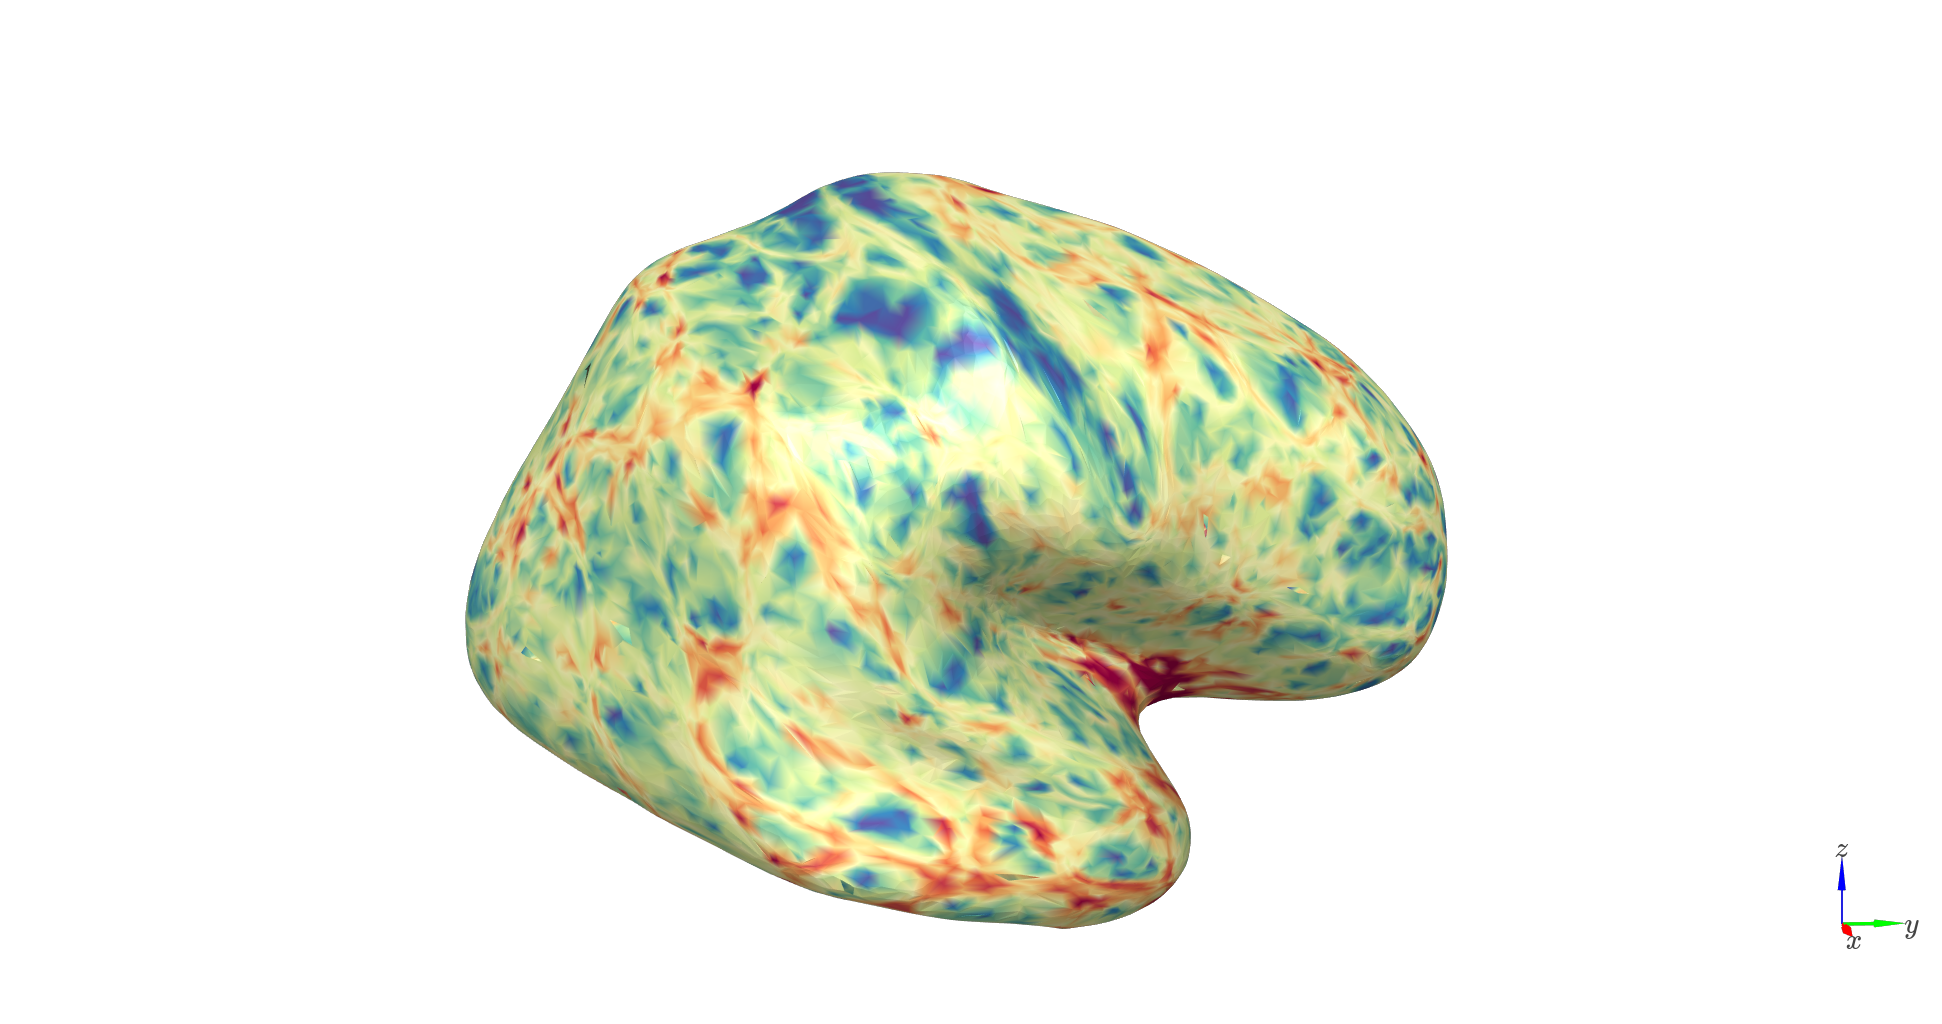

In [12]:
Image(data=base64.b64decode(plot.screenshot))

**Lead-field RMS difference**: quantifies the difference in lead field patterns between the deepest and most superficial vertices; higher values indicate stronger layer separation.

In [14]:
c_range = [np.percentile(lf_rms_diff,1), np.percentile(lf_rms_diff,99)]

# Plot change in power on each surface
colors,_ = color_map(
    lf_rms_diff, 
    "Spectral_r", 
    c_range[0], 
    c_range[1],
    norm='N'
)

cam_view = [335, 9.5, 51,
            60, 37, 17,
            0, 0, 1]

plot = show_surface(
    surf_set, 
    vertex_colors=colors, 
    info=True, 
    camera_view=cam_view
)

Output()

51091 vertices


In [15]:
plot.fetch_screenshot()

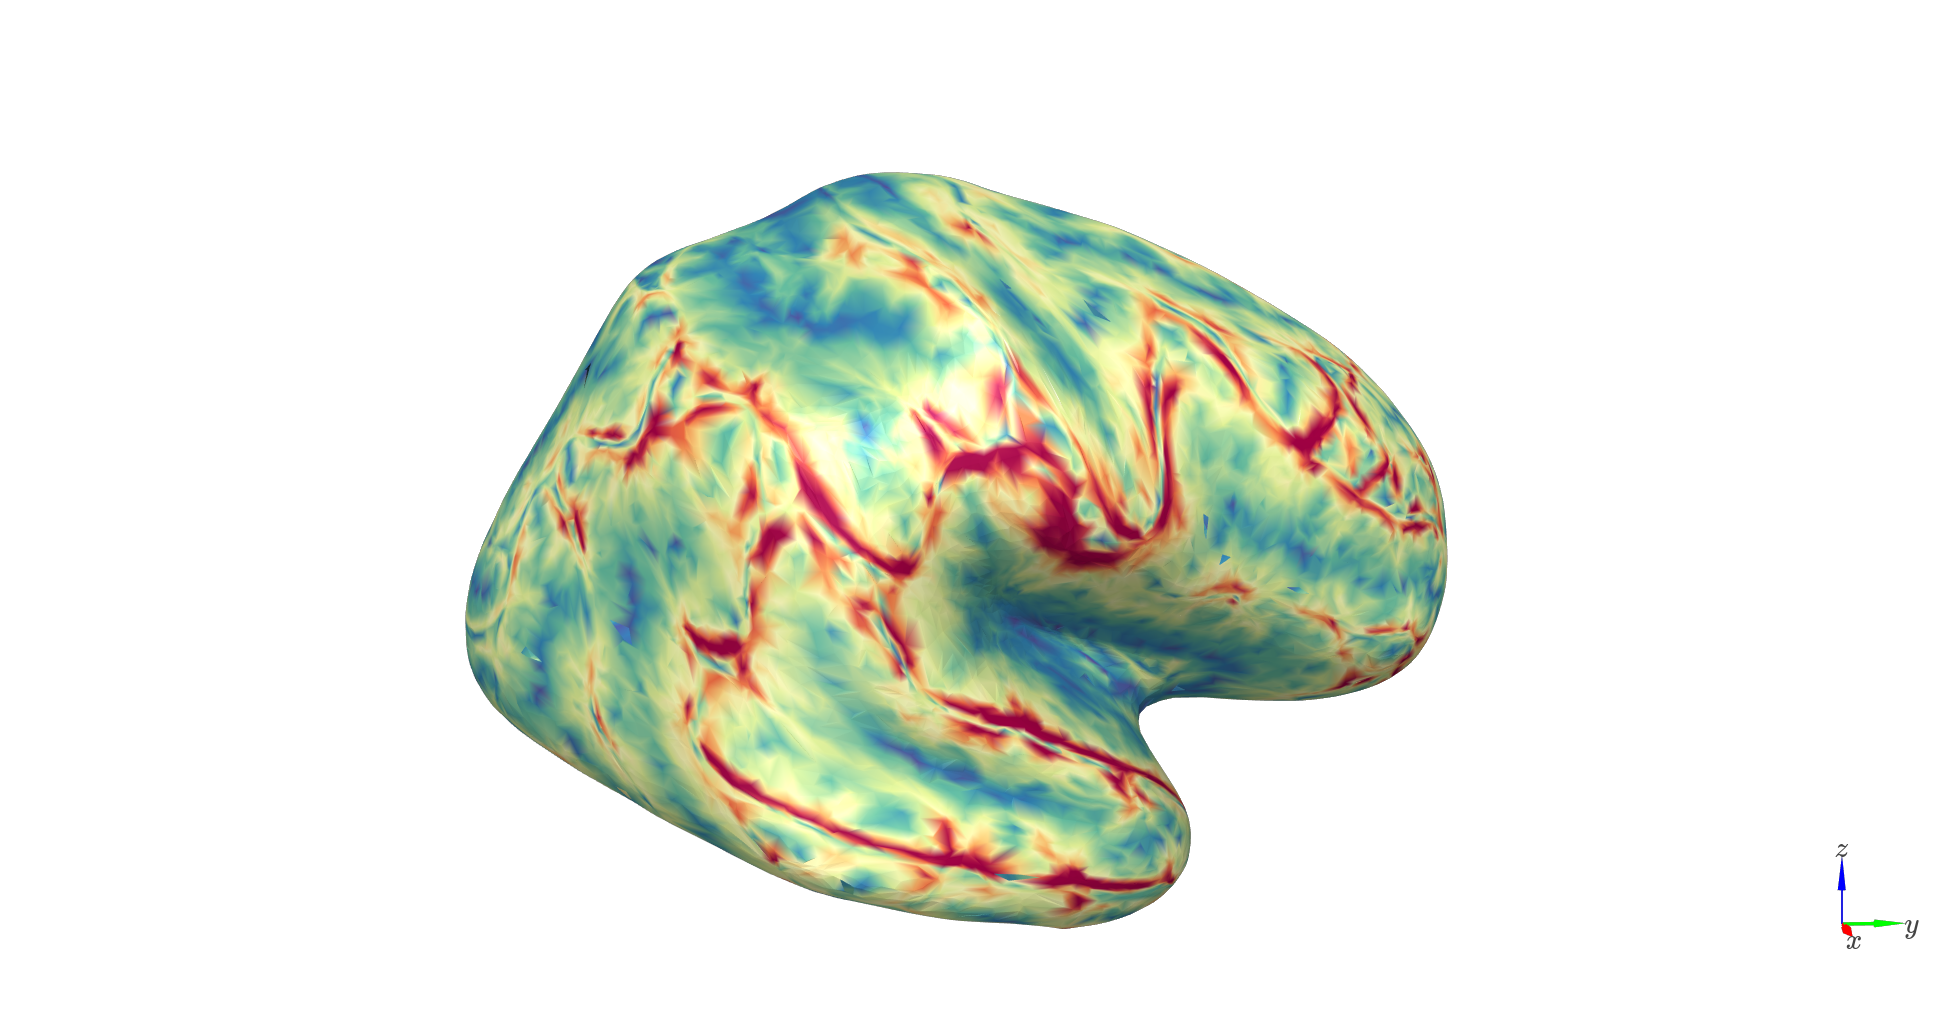

In [16]:
Image(data=base64.b64decode(plot.screenshot))

**Orientation**: measures dipole alignment with scalp normals (1 = radial, 0 = tangential).

In [18]:
c_range = [np.percentile(orientations,1), np.percentile(orientations,99)]

# Plot change in power on each surface
colors,_ = color_map(
    orientations, 
    "Spectral_r", 
    c_range[0], 
    c_range[1],
    norm='N'
)

cam_view = [335, 9.5, 51,
            60, 37, 17,
            0, 0, 1]

plot = show_surface(
    surf_set, 
    vertex_colors=colors, 
    info=True, 
    camera_view=cam_view
)

Output()

51091 vertices


In [19]:
plot.fetch_screenshot()

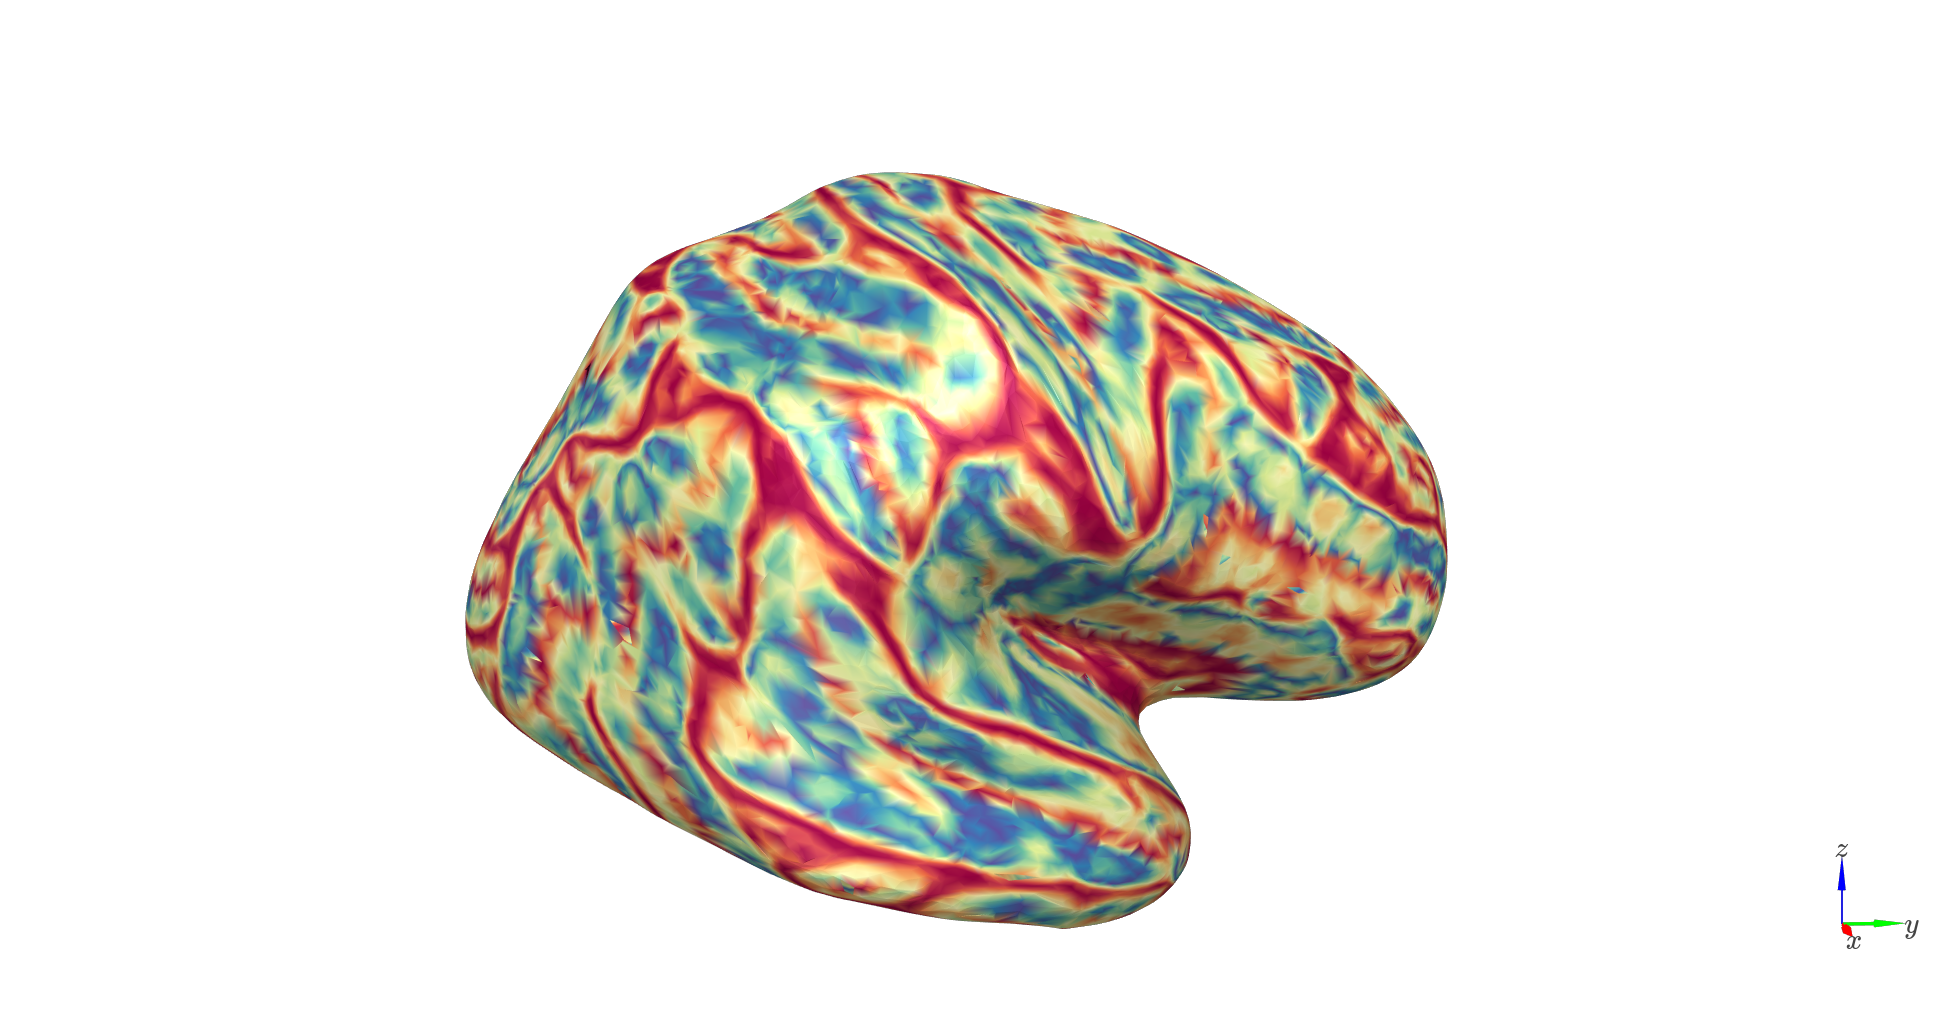

In [20]:
Image(data=base64.b64decode(plot.screenshot))

In [21]:
import base64
import PIL
from io import BytesIO

img_data = base64.b64decode(plot.screenshot)
img = PIL.Image.open(BytesIO(img_data))

img.save("../docs/_static/tutorial_07_orientation.png", format="PNG")

**Distance**: reflects the distance to the scalp

In [22]:
c_range = [np.percentile(distances,1), np.percentile(distances,99)]

# Plot change in power on each surface
colors,_ = color_map(
    distances, 
    "Spectral_r", 
    c_range[0], 
    c_range[1],
    norm='N'
)

cam_view = [335, 9.5, 51,
            60, 37, 17,
            0, 0, 1]

plot = show_surface(
    surf_set, 
    vertex_colors=colors, 
    info=True, 
    camera_view=cam_view
)

Output()

51091 vertices


In [23]:
plot.fetch_screenshot()

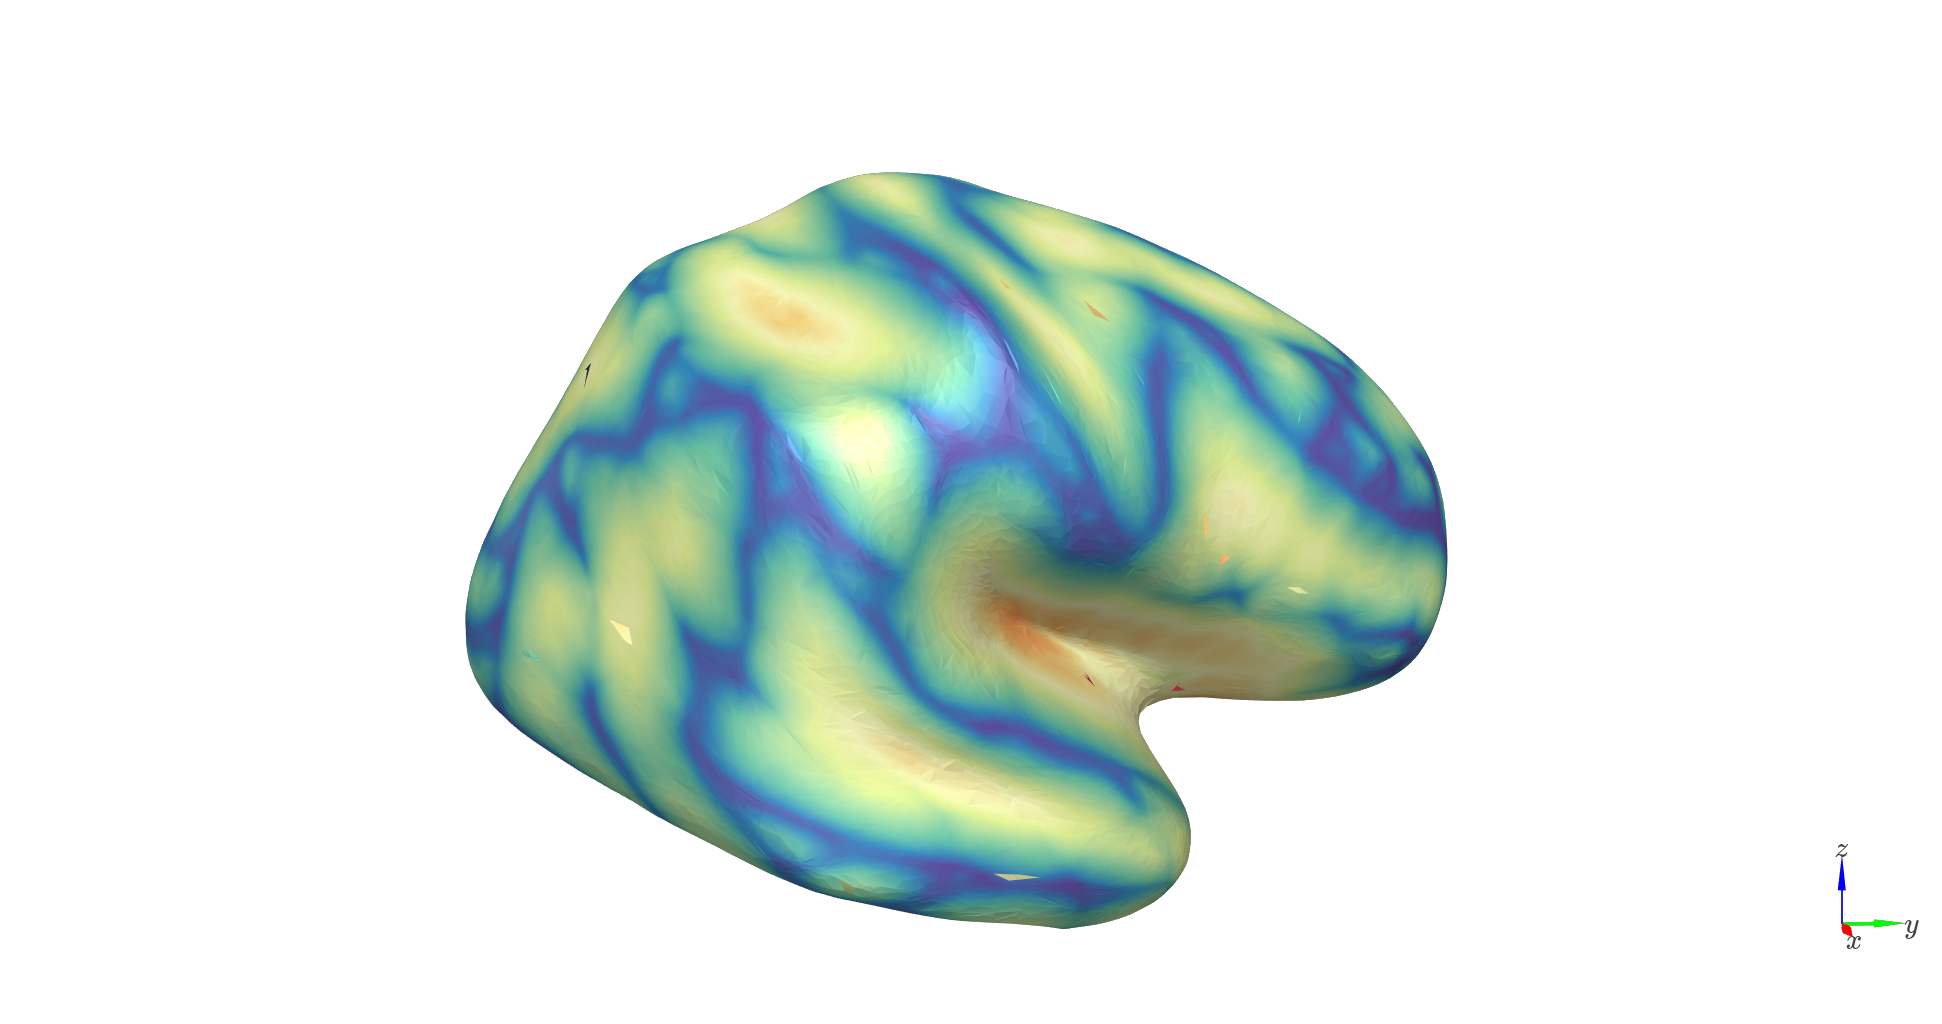

In [25]:
Image(data=base64.b64decode(plot.screenshot))

## Normalize and combine predictors
To assess joint contributions of these features, we standardize (z-score) each anatomical predictor and form a composite 'anatomical score':

In [27]:
# Z-score normalization (invert distance since smaller = closer to sensors)
z_thickness     = zscore(thickness)
z_lf_rms_diff   = zscore(lf_rms_diff)
z_orient    = zscore(orientations)
z_inv_dist  = zscore(-distances)

# Composite anatomical score
anatomical_score = z_thickness + z_lf_rms_diff + z_orient + z_inv_dist

In [28]:
c_range = [np.percentile(anatomical_score,1), np.percentile(anatomical_score,99)]

# Plot change in power on each surface
colors,_ = color_map(
    anatomical_score, 
    "Spectral_r", 
    c_range[0], 
    c_range[1],
    norm='N'
)

cam_view = [335, 9.5, 51,
            60, 37, 17,
            0, 0, 1]

plot = show_surface(
    surf_set, 
    vertex_colors=colors, 
    info=True, 
    camera_view=cam_view
)

Output()

51091 vertices


In [29]:
plot.fetch_screenshot()

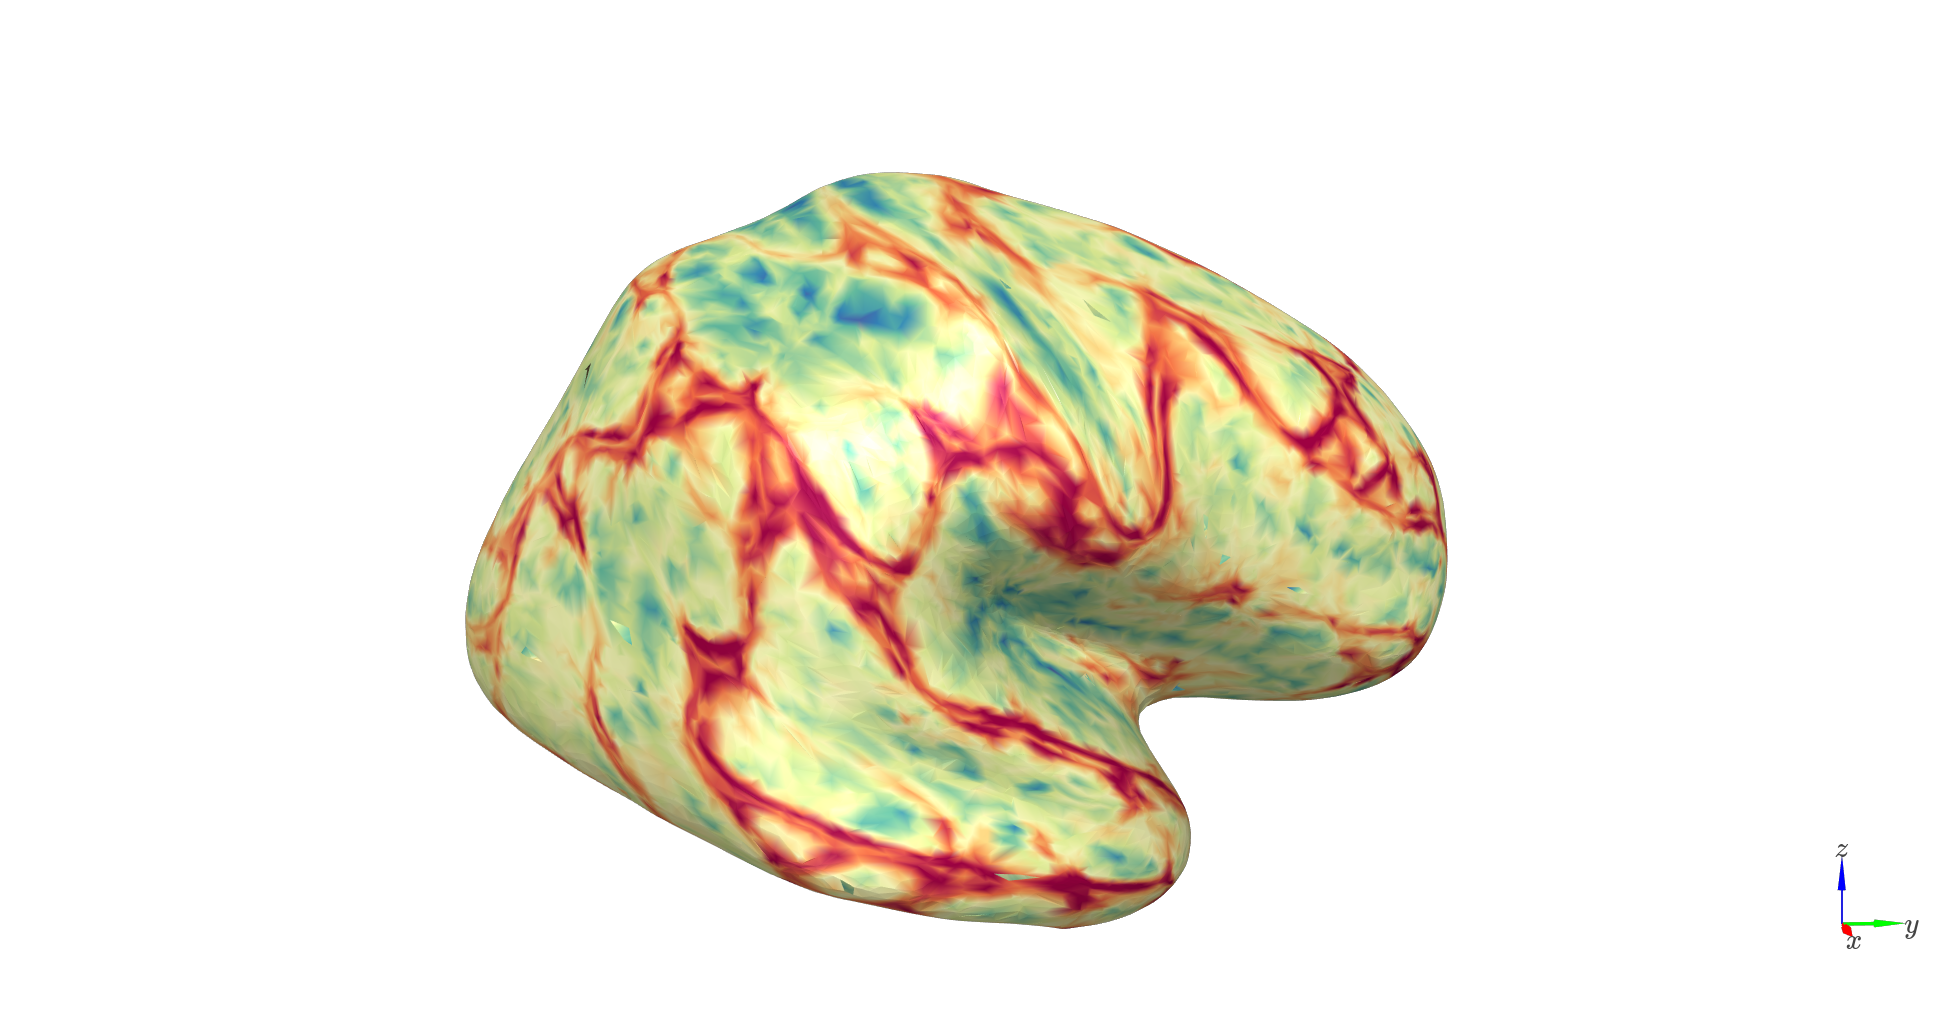

In [31]:
Image(data=base64.b64decode(plot.screenshot))

We can find the best vertex over the whole brain for laminar inference. It happens to be the same one we've been using in the tutorial simulations. Isn't that a coincidence!?

In [35]:
# Vertex with maximal predicted laminar discriminability
best_vertex = np.argmax(anatomical_score)
print(f"Highest anatomical score at vertex {best_vertex}")

Highest anatomical score at vertex 50492


## Interpretation
Vertices with higher anatomical_score values are predicted to yield more accurate laminar inference. That is, lower reconstruction error when differentiating deep vs. superficial sources. In Szul et al., 2025, this multivariate anatomical score closely paralleled empirical reconstruction accuracy maps, highlighting regions where laminar separation is anatomically favorable.

## Selecting anatomical priors within a region of interest
In practical laminar inference, it is often desirable to constrain model comparison to a subset of vertices, e.g., within an anatomical ROI or around vertices showing maximal task-related power or signal amplitude.
Within such a region, the anatomical score can guide the choice of the most anatomically suitable prior location for laminar inference:

In [ ]:
# Among the vertex in roi_idx, select the vertex with the best anatomical suitability
candidate_anat_scores = anatomical_score[roi_idx]
prior_idx = roi_idx[np.argmax(candidate_anat_scores)]

This approach ensures that the prior is anchored at a vertex with the most favorable combination of cortical thickness, lead-field separability, radial orientation, and proximity to sensors, maximizing the likelihood of reliable laminar discrimination within the chosen ROI.

In [37]:
spm.terminate()

# Delete simulation files
shutil.rmtree(tmp_dir)